# Project: Analyze Box Office Data with Seaborn and Python

### Importing Libraries

In [25]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import datetime
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, KFold
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))
import os
import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
import json
import ast
from urllib.request import urlopen
from PIL import Image

### Data Loading and Exploration

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


### Visualizing the Target Distribution

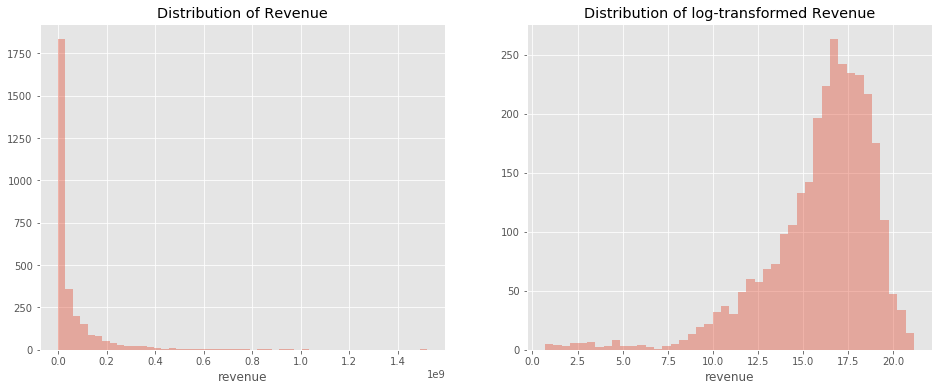

In [4]:
fig, ax = plt.subplots(figsize=(16, 6))
plt.subplot(1, 2, 1)
sns.distplot(train['revenue'], kde=False);
plt.title('Distribution of Revenue');
plt.subplot(1, 2, 2)
sns.distplot(np.log1p(train['revenue']), kde=False);
plt.title('Distribution of log-transformed Revenue');

In [5]:
train['log_revenue'] = np.log1p(train['revenue'])

### Relationship between Film Revenue and Budget

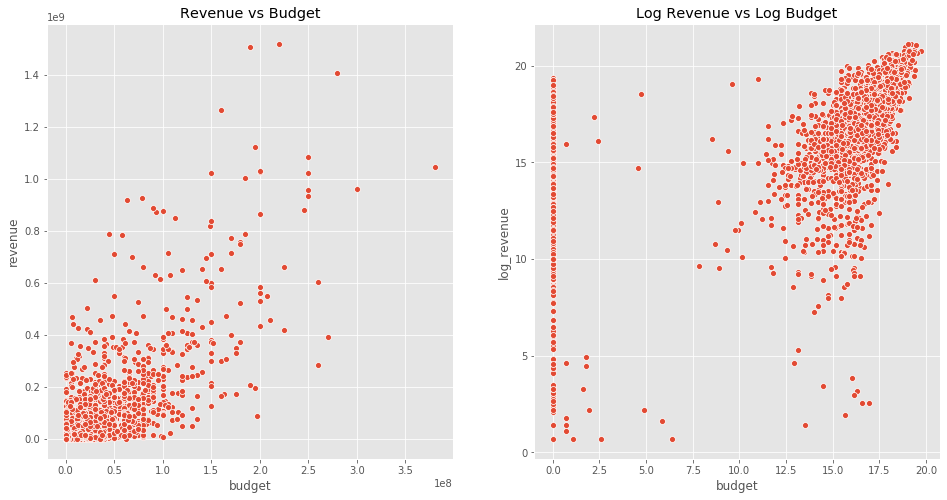

In [6]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(train['budget'], train['revenue'])
plt.title('Revenue vs Budget');
plt.subplot(1, 2, 2)
sns.scatterplot(np.log1p(train['budget']), train['log_revenue'])
plt.title('Log Revenue vs Log Budget');

In [7]:
train['log_budget'] = np.log1p(train['budget'])
test['log_budget'] = np.log1p(test['budget'])

### Does Having an Official Homepage Affect Revenue?

In [8]:
train['homepage'].value_counts().head()

http://www.transformersmovie.com/              4
http://www.thehobbit.com/                      2
http://www.lordoftherings.net/                 2
https://www.facebook.com/bachelorettemovie/    1
http://www.captainphillipsmovie.com            1
Name: homepage, dtype: int64

In [9]:
train['has_homepage'] = 0
train.loc[train['homepage'].isnull() == False, 'has_homepage'] = 1
test['has_homepage'] = 0
test.loc[test['homepage'].isnull() == False, 'has_homepage'] = 1

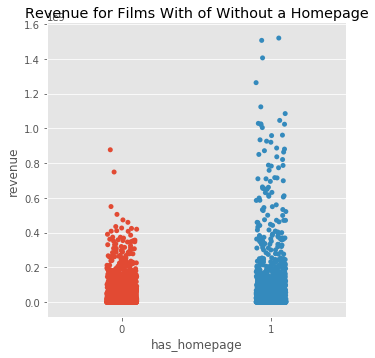

In [10]:
sns.catplot(x='has_homepage', y='revenue', data=train);
plt.title('Revenue for Films With of Without a Homepage');

### Distribution of Languges in Film

In [11]:
language_data = train.loc[train['original_language'].isin(train['original_language'].value_counts().head(10).index)]

Text(0.5, 1.0, 'Mean log Revenue per Language')

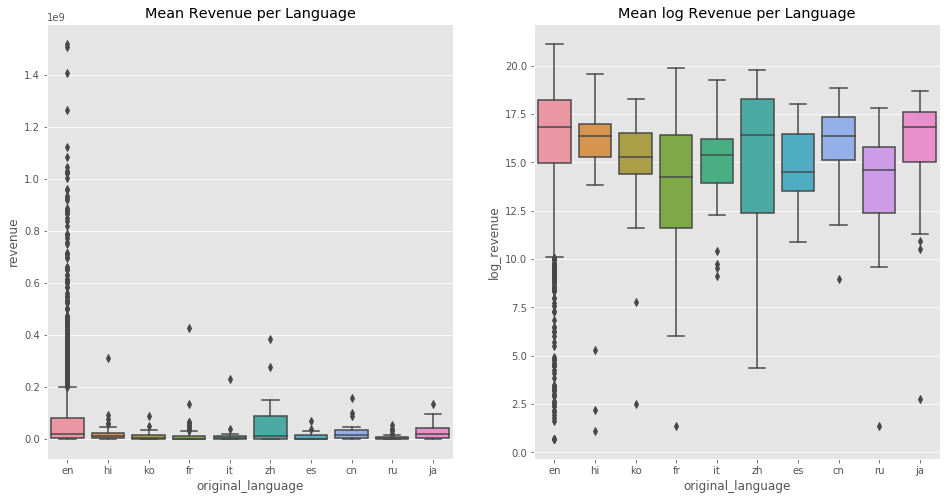

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.boxplot(x='original_language', y='revenue', data=language_data)
plt.title('Mean Revenue per Language')
plt.subplot(1, 2, 2)
sns.boxplot(x='original_language', y='log_revenue', data=language_data)
plt.title('Mean log Revenue per Language')


### Frequent Words in Film Titles and Descriptions

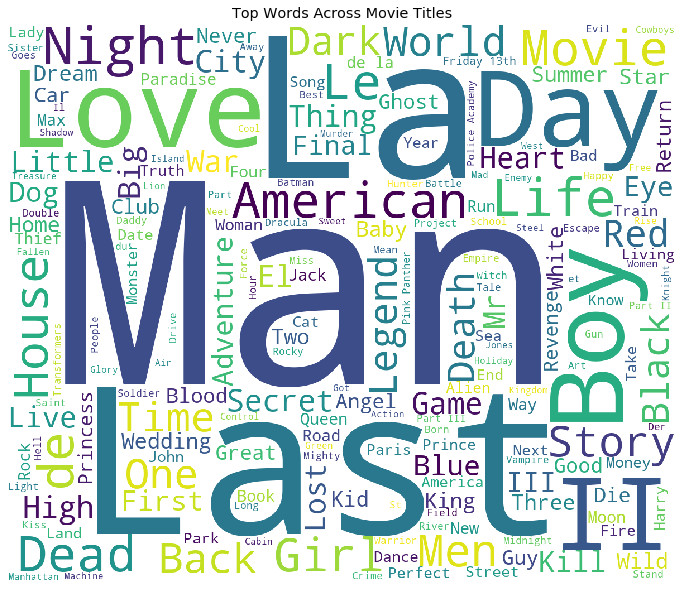

In [13]:
plt.figure(figsize=(12, 12))
text = ' '.join(train['original_title'].values)
wordcloud = WordCloud(max_font_size=None, 
                     background_color='white',
                     width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top Words Across Movie Titles')
plt.axis('off')
plt.show()

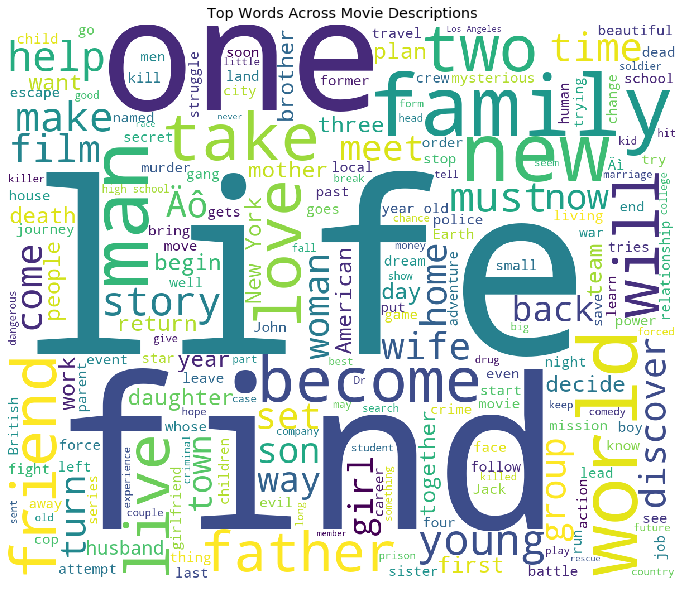

In [14]:
plt.figure(figsize=(12, 12))
text = ' '.join(train['overview'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, 
                     background_color='white',
                     width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top Words Across Movie Descriptions')
plt.axis('off')
plt.show()

### Do Film Descriptions Impact Revenue?

In [15]:
import eli5
from sklearn.linear_model import LinearRegression

In [24]:
vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    analyzer='word', 
    token_pattern=r'\w{1,}',
    ngram_range=(1, 2),
    min_df=5
)

overview_text = vectorizer.fit_transform(train['overview'].fillna(''))
linreg = LinearRegression()
linreg.fit(overview_text, train['log_revenue'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x!= '<BIAS>')